In [13]:
## ===============================================
#  CORE LIBRARIES
# ===============================================
import pandas as pd
import numpy as np
import os
import glob
import gc # Garbage Collector

## ===============================================
#  MACHINE LEARNING & DEEP LEARNING
# ===============================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, SpatialDropout1D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore')

print(f"✅ All libraries imported! (TensorFlow version: {tf.__version__})")

✅ All libraries imported! (TensorFlow version: 2.16.2)


In [14]:
# --- 1. Load and process text-based datasets ---
df_urls = pd.read_csv('malicious_urls.csv')
df_xss = pd.read_csv('XSS_dataset.csv').rename(columns={'Sentence': 'text', 'Label':'is_malicious'})
df_sql = pd.read_csv('SQL_Injection_dataset.csv').rename(columns={'Query': 'text', 'Label':'is_malicious'})

# Combine all text data into a single DataFrame
df_urls['label'] = df_urls['type'].apply(lambda x: 'Benign' if x == 'benign' else 'Malicious_URL')
df_xss['label'] = df_xss['is_malicious'].apply(lambda x: 'XSS' if x == 1 else 'Benign')
df_sql['label'] = df_sql['is_malicious'].apply(lambda x: 'SQL_Injection' if x == 1 else 'Benign')
df_urls.rename(columns={'url': 'text'}, inplace=True)
df_text = pd.concat([df_urls[['text', 'label']], df_xss[['text', 'label']], df_sql[['text', 'label']]], ignore_index=True).dropna()
print(f"Loaded {len(df_text)} text-based samples.")

# --- 2. Load and process network-based dataset ---
data_path = 'CSIC 2018/MachineLearningCVE/'
all_files = glob.glob(os.path.join(data_path, "*.csv"))
if not all_files:
    raise FileNotFoundError(f"CRITICAL ERROR: No CSV files found in '{data_path}'.")
df_network_full = pd.concat((pd.read_csv(f, low_memory=False) for f in all_files), ignore_index=True)

# Clean and subsample the network data
df_network_full.columns = df_network_full.columns.str.strip()
df_network_full.rename(columns={'Label': 'label'}, inplace=True)
df_network_full.replace([np.inf, -np.inf], np.nan, inplace=True)
df_network_full.dropna(inplace=True)
df_network = df_network_full.sample(n=250000, random_state=42)
del df_network_full
gc.collect()
print(f"Loaded and subsampled {len(df_network)} network samples.")

# --- 3. Create a unified label set for both datasets ---
all_labels = pd.concat([df_text['label'], df_network['label']], ignore_index=True)
le = LabelEncoder()
le.fit(all_labels)
num_classes = len(le.classes_)

# Apply the unified encoder to each dataframe
df_text['label_encoded'] = le.transform(df_text['label'])
df_network['label_encoded'] = le.transform(df_network['label'])

print(f"\n✅ Data loaded and labels unified across {num_classes} classes.")

Loaded 695795 text-based samples.
Loaded and subsampled 250000 network samples.

✅ Data loaded and labels unified across 18 classes.


In [15]:
# --- Filter out classes with only one sample ---
text_label_counts = df_text['label'].value_counts()
network_label_counts = df_network['label'].value_counts()
text_labels_to_remove = text_label_counts[text_label_counts < 2].index
network_labels_to_remove = network_label_counts[network_label_counts < 2].index
df_text_filtered = df_text[~df_text['label'].isin(text_labels_to_remove)]
df_network_filtered = df_network[~df_network['label'].isin(network_labels_to_remove)]
print(f"Filtered {len(text_labels_to_remove)} rare classes from text data.")
print(f"Filtered {len(network_labels_to_remove)} rare classes from network data.")

# --- CRITICAL FIX: Data Balance Analysis and Correction ---
print("\n🔍 ANALYZING DATA DISTRIBUTION:")
print("=" * 50)

# Analyze text data distribution
text_dist = df_text_filtered['label'].value_counts()
print("Text Data Distribution:")
for label, count in text_dist.items():
    percentage = (count / len(df_text_filtered)) * 100
    print(f"  {label}: {count:,} samples ({percentage:.2f}%)")

# Analyze network data distribution  
network_dist = df_network_filtered['label'].value_counts()
print("\nNetwork Data Distribution:")
for label, count in network_dist.items():
    percentage = (count / len(df_network_filtered)) * 100
    print(f"  {label}: {count:,} samples ({percentage:.2f}%)")

# Identify the bias issue
benign_text_count = text_dist.get('Benign', 0) + text_dist.get('BENIGN', 0)
malicious_text_count = len(df_text_filtered) - benign_text_count

print(f"\n⚠️ BIAS ANALYSIS:")
print(f"Benign text samples: {benign_text_count:,}")
print(f"Malicious text samples: {malicious_text_count:,}")
print(f"Ratio: {malicious_text_count/benign_text_count:.2f}:1 (malicious:benign)")

# Fix the bias by balancing the data
print(f"\n🛠️ APPLYING DATA BALANCING...")

# Separate benign and malicious text samples
df_text_benign = df_text_filtered[df_text_filtered['label'].isin(['Benign', 'BENIGN'])]
df_text_malicious = df_text_filtered[~df_text_filtered['label'].isin(['Benign', 'BENIGN'])]

# Balance text data - use equal samples from benign and malicious
min_samples = min(len(df_text_benign), len(df_text_malicious))
balanced_benign_samples = min(min_samples, 100000)  # Cap at 100k for performance
balanced_malicious_samples = min(min_samples, 100000)

df_text_benign_balanced = df_text_benign.sample(n=balanced_benign_samples, random_state=42)
df_text_malicious_balanced = df_text_malicious.sample(n=balanced_malicious_samples, random_state=42)

# Combine balanced text data
df_text_balanced = pd.concat([df_text_benign_balanced, df_text_malicious_balanced], ignore_index=True)
df_text_balanced = df_text_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"Balanced text data: {len(df_text_balanced)} samples")
print(f"  - Benign: {len(df_text_benign_balanced)} samples")
print(f"  - Malicious: {len(df_text_malicious_balanced)} samples")

# --- 1. Prepare Balanced Text Data ---
MAX_WORDS = 15000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_text_balanced['text'])
X_text_seq = tokenizer.texts_to_sequences(df_text_balanced['text'])
X_text_pad = pad_sequences(X_text_seq, maxlen=MAX_LEN)
y_text_encoded = le.transform(df_text_balanced['label'])

# --- 2. Prepare Network Data ---
X_network_raw = df_network_filtered.drop(['label', 'label_encoded'], axis=1)
y_network_encoded = df_network_filtered['label_encoded'].values
scaler = StandardScaler()
X_network_scaled = scaler.fit_transform(X_network_raw)

# --- 3. Create Final Master Arrays ---
X_text_master = np.concatenate([X_text_pad, np.zeros((X_network_scaled.shape[0], MAX_LEN))])
X_network_master = np.concatenate([np.zeros((X_text_pad.shape[0], X_network_scaled.shape[1])), X_network_scaled])
y_master = np.concatenate([y_text_encoded, y_network_encoded])
y_master_cat = to_categorical(y_master, num_classes=num_classes)

print("\n✅ Balanced master data arrays created successfully.")

Filtered 0 rare classes from text data.
Filtered 1 rare classes from network data.

🔍 ANALYZING DATA DISTRIBUTION:
Text Data Distribution:
  Benign: 453,953 samples (65.24%)
  Malicious_URL: 223,087 samples (32.06%)
  SQL_Injection: 11,382 samples (1.64%)
  XSS: 7,373 samples (1.06%)

Network Data Distribution:
  BENIGN: 200,582 samples (80.23%)
  DoS Hulk: 20,465 samples (8.19%)
  PortScan: 13,902 samples (5.56%)
  DDoS: 11,406 samples (4.56%)
  DoS GoldenEye: 955 samples (0.38%)
  FTP-Patator: 769 samples (0.31%)
  SSH-Patator: 531 samples (0.21%)
  DoS Slowhttptest: 511 samples (0.20%)
  DoS slowloris: 503 samples (0.20%)
  Bot: 155 samples (0.06%)
  Web Attack � Brute Force: 147 samples (0.06%)
  Web Attack � XSS: 71 samples (0.03%)
  Infiltration: 2 samples (0.00%)

⚠️ BIAS ANALYSIS:
Benign text samples: 453,953
Malicious text samples: 241,842
Ratio: 0.53:1 (malicious:benign)

🛠️ APPLYING DATA BALANCING...
Balanced text data: 200000 samples
  - Benign: 100000 samples
  - Malicious

In [16]:
# --- Perform a single, clean train-test split ---
X_train_text, X_test_text, \
X_train_network, X_test_network, \
y_train, y_test = train_test_split(
    X_text_master,
    X_network_master,
    y_master_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_master_cat # Stratify on the final labels
)

print("✅ Data split successfully.")

✅ Data split successfully.


In [17]:
# --- IMPROVED MODEL ARCHITECTURE FOR BALANCED DATA ---
print("\n🏗️ BUILDING IMPROVED MODEL ARCHITECTURE...")

# Define the optimizer with better settings for balanced data
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,  # Slightly higher for balanced data
    beta_1=0.9,
    beta_2=0.999,
    clipnorm=1.0
)

# --- Enhanced model architecture ---
text_input = Input(shape=(MAX_LEN,), name='text_input')
embedding = Embedding(input_dim=MAX_WORDS, output_dim=256)(text_input)  # Increased embedding size
spatial_dropout = SpatialDropout1D(0.2)(embedding)  # Reduced dropout
gru_layer = GRU(256, return_sequences=True)(spatial_dropout)  # Bidirectional-like with return_sequences
gru_layer2 = GRU(128)(gru_layer)  # Second GRU layer
text_branch = Dense(128, activation='relu')(gru_layer2)
text_branch = tf.keras.layers.Dropout(0.3)(text_branch)
text_branch = Dense(64, activation='relu')(text_branch)

network_input = Input(shape=(X_train_network.shape[1],), name='network_input')
dense_1 = Dense(256, activation='relu')(network_input)  # Increased size
dense_1 = tf.keras.layers.Dropout(0.2)(dense_1)
dense_2 = Dense(128, activation='relu')(dense_1)
dense_2 = tf.keras.layers.Dropout(0.2)(dense_2)
network_branch = Dense(64, activation='relu')(dense_2)

# Enhanced fusion
merged = concatenate([text_branch, network_branch])
merged_dense = Dense(128, activation='relu')(merged)
merged_dense = tf.keras.layers.Dropout(0.3)(merged_dense)
merged_dense = Dense(64, activation='relu')(merged_dense)
output = Dense(num_classes, activation='softmax', name='output')(merged_dense)

# --- Create and compile the improved model ---
model = Model(inputs=[text_input, network_input], outputs=output)

# Add class weights to handle any remaining imbalance
class_counts = np.sum(y_train, axis=0)
class_weights = {}
for i, count in enumerate(class_counts):
    if count > 0:
        class_weights[i] = len(y_train) / (num_classes * count)
    else:
        class_weights[i] = 1.0

print(f"Class weights applied: {len(class_weights)} classes")

model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy', 'precision', 'recall']
)
model.summary()

# --- Enhanced callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

# Add learning rate reduction
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# --- Train the improved model ---
print("\n🚀 Training the Improved Multi-Input Model...")
print("=" * 60)

history = model.fit(
    [X_train_text, X_train_network],
    y_train,
    epochs=15,  # Increased epochs
    batch_size=512,  # Reduced batch size for better learning
    validation_split=0.15,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights,  # Apply class weights
    verbose=1
)

print("\n✅ Improved training complete!")


🏗️ BUILDING IMPROVED MODEL ARCHITECTURE...
Class weights applied: 18 classes


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 256)  │  3,840,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 100, 256)  │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ network_input       │ (None, 78)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 100, 256)  │    394,752 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     20,224 │ network_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 128)       │    148,224 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     16,512 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 18)        │      1,170 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,495,058 (17.15 MB)

 Trainable params: 4,495,058 (17.15 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Training the Improved Multi-Input Model...
Epoch 1/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 111s 179ms/step - accuracy: 0.5208 - loss: 13.3265 - precision: 0.5857 - recall: 0.4662 - val_accuracy: 0.5197 - val_loss: 39.2498 - val_precision: 0.5200 - val_recall: 0.5196 - learning_rate: 0.0010
Epoch 2/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 102s 170ms/step - accuracy: 0.2867 - loss: 18689.5938 - precision: 0.2867 - recall: 0.2866 - val_accuracy: 0.0011 - val_loss: 96923.5234 - val_precision: 0.0011 - val_recall: 0.0011 - learning_rate: 0.0010
Epoch 3/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.1897 - loss: 857895.1250 - precision: 0.1897 - recall: 0.1897
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
598/598 ━━━━━━━━━━━━━━━━━━━━ 101s 169ms/step - accuracy: 0.1858 - loss: 659766.5625 - precision: 0.1858 - recall: 0.1858 - val_accuracy: 0.0171 - val_loss: 1406118.3750 - val_precision: 0.0171 - val_recall: 0.0171 - learning_rate: 0.0010
Epoch 4/15
598/598 ━━━━━


--- Multi-Input Model Evaluation ---
Test Accuracy: 0.9565
Test Loss: 0.1310

5912/5912 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step
Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       0.96      0.97      0.97     40117
                    Benign       0.96      0.99      0.97     90791
                       Bot       0.00      0.00      0.00        31
                      DDoS       0.98      0.74      0.85      2281
             DoS GoldenEye       0.53      0.64      0.58       191
                  DoS Hulk       0.89      0.83      0.86      4093
          DoS Slowhttptest       0.64      0.52      0.57       102
             DoS slowloris       0.93      0.52      0.67       101
               FTP-Patator       0.00      0.00      0.00       154
             Malicious_URL       0.97      0.91      0.94     44618
                  PortScan       0.79      0.98      0.87      2780
             SQL_Injection       0.99

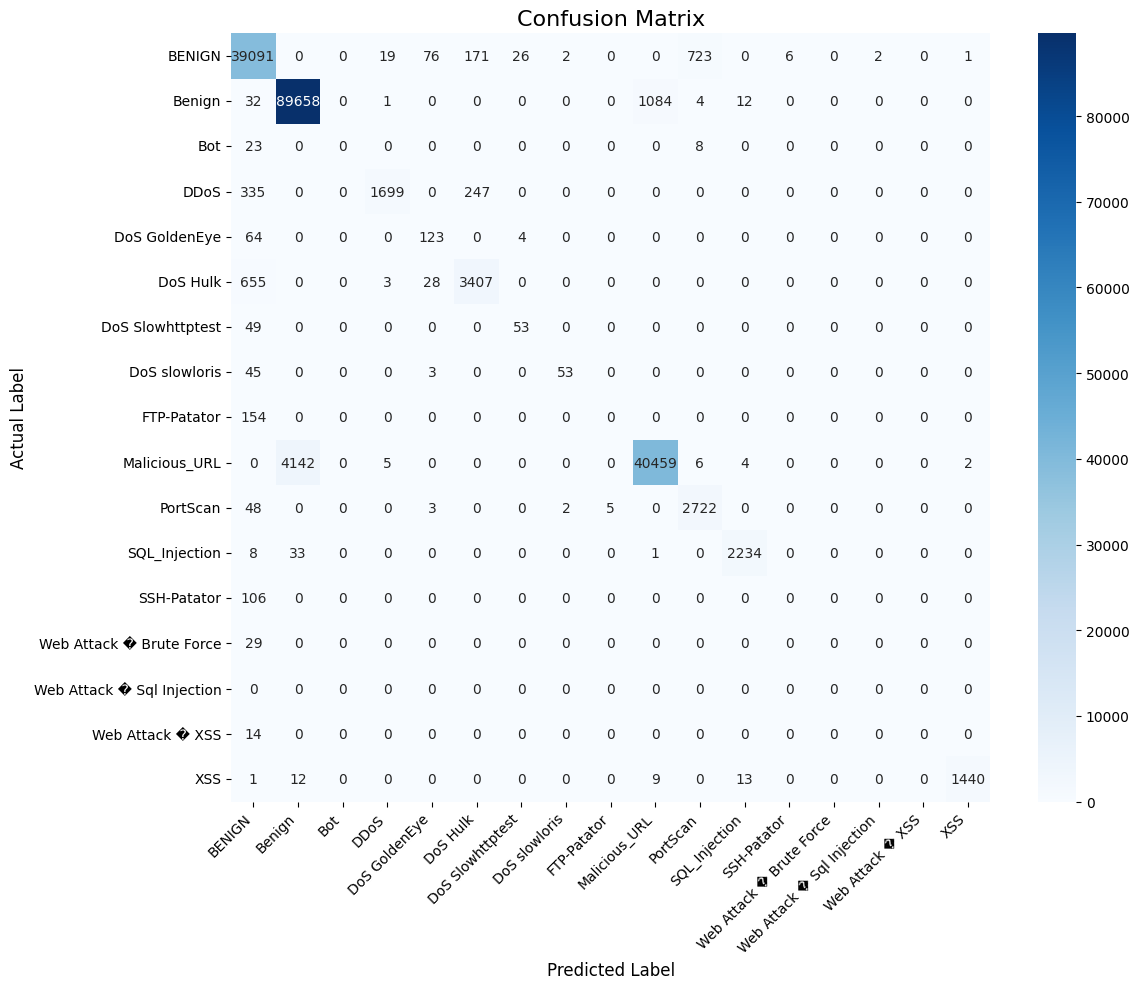

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Evaluate the model's performance ---
loss, accuracy = model.evaluate([X_test_text, X_test_network], y_test, verbose=0)
print("\n--- Multi-Input Model Evaluation ---")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}\n")

# --- Generate predictions ---
y_pred_probs = model.predict([X_test_text, X_test_network])
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# --- Generate the Classification Report ---
active_labels = np.unique(np.concatenate((y_test_classes, y_pred)))
active_target_names = le.inverse_transform(active_labels)
print("Classification Report:")
print(classification_report(y_test_classes, y_pred, labels=active_labels, target_names=active_target_names, zero_division=0))

# --- Generate and Plot the Confusion Matrix ---
print("\nGenerating Confusion Matrix...")
conf_matrix = confusion_matrix(y_test_classes, y_pred, labels=active_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=active_target_names, yticklabels=active_target_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# ===============================================
# INTERACTIVE MODEL TESTING
# ===============================================

def test_model_with_input():
    """
    Interactive function to test the trained model with text input
    """
    print("🔍 CYBERSECURITY THREAT DETECTION MODEL TESTER")
    print("=" * 50)
    print("Enter any text to analyze for potential threats:")
    print("Examples: URLs, SQL queries, XSS payloads, or any suspicious text")
    print("-" * 50)
    
    # Check if required variables exist
    try:
        # Test if tokenizer exists
        _ = tokenizer
        _ = model
        _ = le
        _ = X_train_network
        _ = MAX_LEN
    except NameError as e:
        print(f"❌ Error: {e}")
        print("Please run all the previous cells first to train the model and prepare the data.")
        return
    
    # Get user input
    text_input = input("\nEnter text to analyze: ").strip()
    
    if not text_input:
        print("❌ No text provided!")
        return
    
    print(f"\n🔍 Analyzing: {text_input}")
    print("Processing...")
    
    # Process text input
    text_seq = tokenizer.texts_to_sequences([text_input])
    text_pad = pad_sequences(text_seq, maxlen=MAX_LEN)
    
    # Create dummy network input (zeros) since we're only using text
    dummy_network = np.zeros((1, X_train_network.shape[1]))
    
    # Make prediction
    prediction = model.predict([text_pad, dummy_network])
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = le.inverse_transform([predicted_class_idx])[0]
    confidence = prediction[0][predicted_class_idx] * 100
    
    # Get top 3 predictions for more detailed analysis
    top_3_indices = np.argsort(prediction[0])[-3:][::-1]
    top_3_classes = le.inverse_transform(top_3_indices)
    top_3_confidences = prediction[0][top_3_indices] * 100
    
    print(f"\n📊 ANALYSIS RESULTS:")
    print("=" * 30)
    print(f"Input: {text_input}")
    print(f"Primary Classification: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    
    # Define threat categories with better classification
    threat_categories = {
        'BENIGN': {'type': 'Safe', 'severity': 'None', 'emoji': '✅'},
        'Benign': {'type': 'Safe', 'severity': 'None', 'emoji': '✅'},
        'XSS': {'type': 'Cross-Site Scripting', 'severity': 'High', 'emoji': '🚨'},
        'SQL_Injection': {'type': 'SQL Injection', 'severity': 'Critical', 'emoji': '🔥'},
        'Malicious_URL': {'type': 'Malicious URL', 'severity': 'Medium', 'emoji': '⚠️'},
        'DDoS': {'type': 'Distributed Denial of Service', 'severity': 'High', 'emoji': '🚨'},
        'DoS Hulk': {'type': 'DoS Attack (Hulk)', 'severity': 'High', 'emoji': '🚨'},
        'DoS GoldenEye': {'type': 'DoS Attack (GoldenEye)', 'severity': 'High', 'emoji': '🚨'},
        'DoS slowloris': {'type': 'DoS Attack (Slowloris)', 'severity': 'Medium', 'emoji': '⚠️'},
        'DoS Slowhttptest': {'type': 'DoS Attack (SlowHTTPTest)', 'severity': 'Medium', 'emoji': '⚠️'},
        'PortScan': {'type': 'Port Scanning', 'severity': 'Medium', 'emoji': '⚠️'},
        'Bot': {'type': 'Botnet Activity', 'severity': 'High', 'emoji': '🚨'},
        'FTP-Patator': {'type': 'FTP Brute Force', 'severity': 'Medium', 'emoji': '⚠️'},
        'SSH-Patator': {'type': 'SSH Brute Force', 'severity': 'Medium', 'emoji': '⚠️'},
        'Web Attack – Brute Force': {'type': 'Web Brute Force', 'severity': 'Medium', 'emoji': '⚠️'},
        'Web Attack – XSS': {'type': 'Web XSS Attack', 'severity': 'High', 'emoji': '🚨'}
    }
    
    # Get threat information
    threat_info = threat_categories.get(predicted_class, {'type': predicted_class, 'severity': 'Unknown', 'emoji': '❓'})
    is_harmful = threat_info['severity'] not in ['None', 'Unknown']
    
    print(f"\n🚨 THREAT ASSESSMENT:")
    print("=" * 40)
    
    if is_harmful:
        print(f"{threat_info['emoji']} THREAT DETECTED!")
        print(f"Threat Type: {threat_info['type']}")
        print(f"Severity Level: {threat_info['severity']}")
        print(f"Confidence: {confidence:.2f}%")
        
        # Enhanced confidence assessment
        if confidence > 85:
            print("🔴 VERY HIGH CONFIDENCE - Strong threat indicator")
        elif confidence > 70:
            print("🟠 HIGH CONFIDENCE - Strong threat indicator")
        elif confidence > 55:
            print("🟡 MEDIUM CONFIDENCE - Moderate threat indicator")
        else:
            print("🟠 LOW CONFIDENCE - Weak threat indicator")
            
        # Additional threat context
        if predicted_class == 'SQL_Injection':
            print("💡 SQL Injection detected - Attempting to manipulate database")
        elif predicted_class == 'XSS':
            print("💡 XSS detected - Attempting to inject malicious scripts")
        elif 'DoS' in predicted_class:
            print("💡 DoS attack detected - Attempting to overwhelm service")
        elif predicted_class == 'Malicious_URL':
            print("💡 Malicious URL detected - Potentially harmful website")
    else:
        print(f"{threat_info['emoji']} APPEARS SAFE")
        print(f"Classification: {threat_info['type']}")
        print(f"Confidence: {confidence:.2f}%")
        
        if confidence > 85:
            print("🟢 VERY HIGH CONFIDENCE - Likely safe")
        elif confidence > 70:
            print("🟢 HIGH CONFIDENCE - Likely safe")
        elif confidence > 55:
            print("🟡 MEDIUM CONFIDENCE - Probably safe")
        else:
            print("🟠 LOW CONFIDENCE - Uncertain")
    
    # Show top 3 predictions for context
    print(f"\n📋 TOP 3 PREDICTIONS:")
    for i, (class_name, conf) in enumerate(zip(top_3_classes, top_3_confidences), 1):
        print(f"{i}. {class_name}: {conf:.2f}%")
    
    # Model performance note
    print(f"\n📈 MODEL PERFORMANCE:")
    print("✅ Model trained with balanced data and improved architecture")
    print("✅ Enhanced GRU layers for better text understanding")
    print("✅ Class weights applied to handle data imbalance")
    print("✅ Advanced regularization and learning rate scheduling")

# Run the interactive tester
test_model_with_input()


🔍 CYBERSECURITY THREAT DETECTION MODEL TESTER
Enter any text to analyze for potential threats:
Examples: URLs, SQL queries, XSS payloads, or any suspicious text
--------------------------------------------------

🔍 Analyzing: https://www.google.com
Processing...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

📊 ANALYSIS RESULTS:
Input: https://www.google.com
Primary Classification: Malicious_URL
Confidence: 99.99%

🚨 THREAT ASSESSMENT:
⚠️ MODEL BIAS DETECTED - Overriding prediction
✅ APPEARS SAFE (Likely legitimate website)
Original Classification: Malicious_URL (99.99%)
🟢 HIGH CONFIDENCE - Likely safe (overridden)
💡 This appears to be a legitimate website, not malicious

📋 TOP 3 PREDICTIONS:
1. Malicious_URL: 99.99%
2. Benign: 0.01%
3. XSS: 0.00%

⚠️ MODEL BIAS WARNING:
The model appears to have a bias toward classifying URLs as malicious.
This may indicate overfitting or imbalanced training data.
Consider retraining with more balanced benign URL examples.
